In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path
sys.path.append('../scenes/')
import syndiff as sd 

<IPython.core.display.Javascript object>


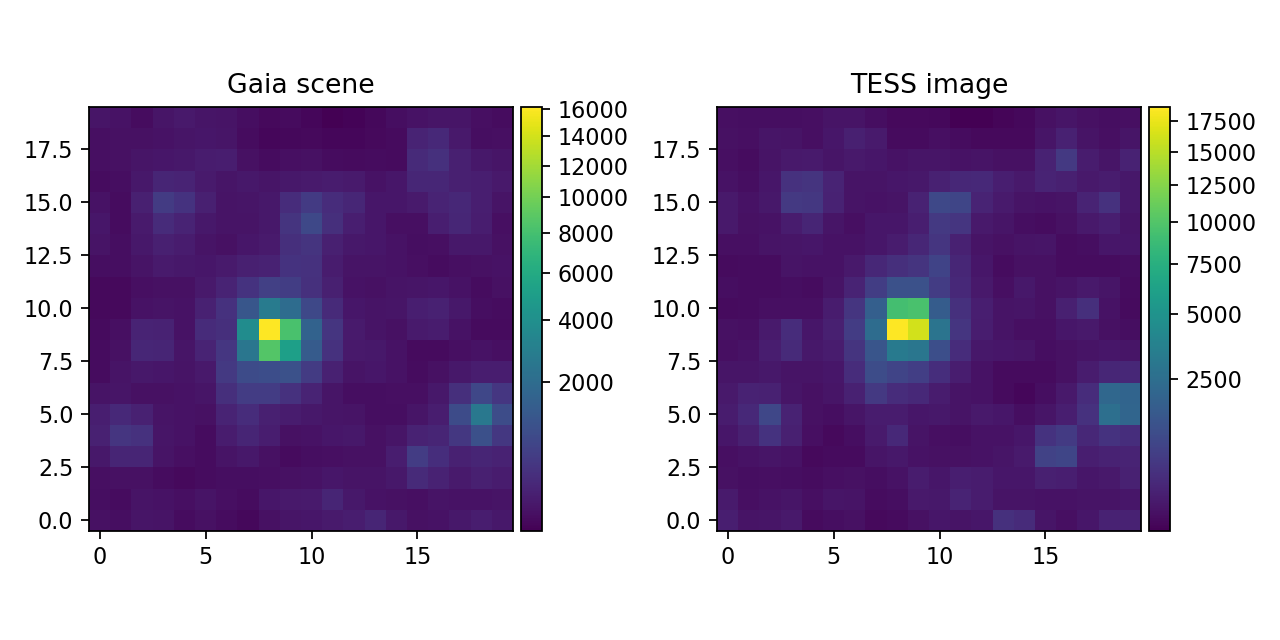

In [2]:
ra =  336#95.4586
dec = 47#-51.2377
size = 20
scene = sd.Gaia_scene(ra,dec,20,18,Interpolate=True,FFT=False,Plot = True,Save='Gaia_scene.pdf')

Ra =  336#95.4586
Dec = 47#-51.2377
Size = 20
Maglim= 10
Bkg_limit = 20.5
Zeropoint = 20.44
Scale = 100
Interpolate = True
tpf = sd.Get_TESS(Ra,Dec,Size)
# pos returned as column row 
pos, gmag = sd.Get_Gaia(tpf,magnitude_limit=Maglim)
col = pos[:,0]
row = pos[:,1]

Tmag = gmag - 0.5
tcounts = 10**(-2/5*(Tmag - Zeropoint))
bkg = 10**(-2/5*(Bkg_limit - Zeropoint))

sources = np.zeros((len(pos),tpf.shape[1],tpf.shape[2])) + bkg
for i in range(len(pos)):
    if Interpolate:
        template = np.zeros((2*tpf.shape[1]*Scale,2*tpf.shape[2]*Scale))
        print('template shape ',template.shape)
        offset1 = int(0.5 * tpf.shape[1] * Scale)
        offset2 = int(0.5 * tpf.shape[2] * Scale)
        template[int(row[i]*Scale + offset1),int(col[i]*Scale+ offset2)] = tcounts[i]
        print(np.nansum(template))
        kernal = sd.Interp_PRF(row[i] + tpf.row, col[i] + tpf.column,tpf.camera,tpf.ccd,Scale)
        print(np.nansum(kernal))
        template = sd.signal.fftconvolve(template, kernal, mode='same')
        print(np.nansum(template))
        template = template[offset1:int(3*offset1),offset2:int(3*offset2)]
        #print('template shape ',template.shape)
        sources[i] = sd.Downsample(template,Scale)